# Imports

In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import hellinger_fidelity


# Operators from Qiskit
from qiskit.quantum_info import SparsePauliOp

# Ansatz import
from qiskit.circuit.library import RealAmplitudes

# Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Setup: Test circuit

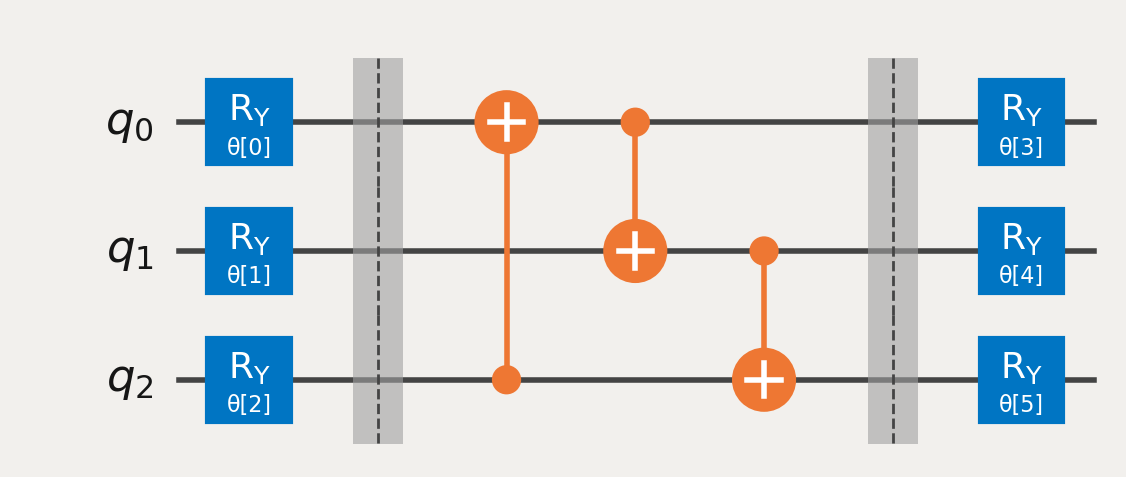

In [2]:
N = 3
ansatz = RealAmplitudes(num_qubits=N, reps=1, entanglement="circular", insert_barriers=True)
qc = ansatz.decompose()
qc.draw('mpl')

# Qiskit Runtime Primitive: Estimator

In [3]:
instance = "system-request/7-14-23-access/main"
service = QiskitRuntimeService(instance=instance)

In [4]:
# very similar to the Sampler construct. Only addition is the `observables` parameter
# estimator jobs need an operator
def run_with_estimator_in_session(circuits, observables, service, estimator_name, params=None, options=None):
    """Wrapper for running circuits with runtime Sampler inside a Session.
    We will be re-using this construct a number of time. Therefore, it is warpped
    insided a function for re-usability.
    """
    with Session(service=service, backend=estimator_name) as session:
        estimator = Estimator(session=session, options=options)
        job = estimator.run(circuits, observables, parameter_values=params)
        result = job.result()

    session.close()
    
    return result

In [5]:
estimator_name = "ibmq_qasm_simulator"
oper = SparsePauliOp.from_list([
    ("IIZ", 1.0),
    ("XIY", -0.5),
    ("ZYX", 1.0)
])

# create some random initial parameters
num_params = ansatz.num_parameters
np.random.seed(0)
init_params = 2 * np.pi * np.random.random(num_params)
reps = 5
res = run_with_estimator_in_session(
    circuits=[qc]*reps,
    observables=[oper]*reps,
    service=service,
    params=[init_params]*reps,
    estimator_name=estimator_name
)
ideal_expvals = res.values # estimator returns expectation "values" whereas sampler returns "quasi-distributions"
ideal_expvals

array([-0.633  , -0.6375 , -0.64175, -0.63   , -0.6495 ])

## Configuring Estimator Options

In [6]:
options = Options()
options.optimization_level = 0
options.resilience_level = 0
options.execution.shots = 10000

In [7]:
res = run_with_estimator_in_session(
    circuits=qc,
    observables=oper,
    service=service,
    params=init_params,
    estimator_name=estimator_name,
    options=options
)
print(f"Ideal expectation values: {res.values}")

Ideal expectation values: [-0.6536]


## Noisy Simulation with Runtime Estimator

In [8]:
# fetch a noise model from backend
from qiskit_aer.noise import NoiseModel

backend = service.get_backend("ibm_peekskill")

noise_model = NoiseModel.from_backend(backend)

In [9]:
options.simulator.noise_model = noise_model
options.simulator.basis_gates = backend.operation_names
options.simulator.coupling_map = backend.coupling_map

In [10]:
res_noisy = run_with_estimator_in_session(
    circuits=qc,
    observables=oper,
    service=service,
    params=init_params,
    estimator_name=estimator_name,
    options=options
)
print(f"Noisy expectation values: {res_noisy.values}")

Noisy expectation values: [-0.5994]


In [11]:
options.simulator.set_backend(backend) # avaialble from qiskit-ibm-runtime 0.11.2

In [12]:
res_noisy = run_with_estimator_in_session(
    circuits=qc,
    observables=oper,
    service=service,
    params=init_params,
    estimator_name=estimator_name,
    options=options
)
print(f"Noisy expectation values: {res_noisy.values}")

Noisy expectation values: [-0.5803]


## Error Suppression and Mitigation with Estimator

| Optimization Level | Sampler and Estimator |
| --- | --- |
| **Level 0** | No optimization and  no error suppression |
| **Level 1** | Light optimization and Dynamical Decoupling | 
| **Level 2** | Medium optimization and Dynamical Decoupling | 
| **Level 3** | Heavy optimization and Dynamical Decoupling | 

| Resilience Levels | Sampler | Estimator |
| --- | --- | --- |
| **Level 0** | No mitigation | No mitigation | 
| **Level 1** (default) | M3 readout correction | TREX readout correction | 
| **Level 2** | No mitigation | ZNE (no readout correction) | 
| **Level 3** | No mitigation | PEC | 

### Measurement Mitigation ( and Dynamical Decoupling)

In [13]:
options.optimization_level = 3 # > 0 enables dynamical decoupling
options.resilience_level = 1 # measurement error mitigation with TReX

In [14]:
res_mitigated = run_with_estimator_in_session(
    circuits=qc,
    observables=oper,
    service=service,
    params=init_params,
    estimator_name=estimator_name,
    options=options
)
print(f"Mitigated expectation values (DD+TReX): {res_mitigated.values}")

Mitigated expectation values (DD+TReX): [-0.62086975]


In [15]:
res_mitigated.metadata[0]

{'variance': 2.02970964273413,
 'shots': 10000,
 'readout_mitigation_num_twirled_circuits': 16,
 'readout_mitigation_shots_calibration': 8192}

### ZNE

In [16]:
options.resilience_level = 2 # level = 2 activates ZNE

In [17]:
from pprint import pprint
pprint(options)

Options(optimization_level=3,
        resilience_level=2,
        max_execution_time=None,
        transpilation=TranspilationOptions(skip_transpilation=False,
                                           initial_layout=None,
                                           layout_method=None,
                                           routing_method=None,
                                           approximation_degree=None),
        resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier',
                                     noise_factors=(1, 3, 5),
                                     extrapolator='LinearExtrapolator'),
        execution=ExecutionOptions(shots=10000, init_qubits=True),
        environment=EnvironmentOptions(log_level='WARNING',
                                       callback=None,
                                       job_tags=[]),
        simulator=SimulatorOptions(noise_model=<NoiseModel on ['cx', 'reset', 'x', 'id', 'measure', 'sx']>,
                           

In [18]:
# Choices: 'TwoQubitAmplifier' | 'CxAmplifier' | 'LocalFoldingAmplifier' | 'GlobalFoldingAmplifier'
options.resilience.noise_amplifier = "LocalFoldingAmplifier"

# Noise factors can be floats. The factors must be >= 1
options.resilience.noise_factors = (1, 1.5, 2)

# Choices: 'LinearExtrapolator' | 'QuadraticExtrapolator' | 'CubicExtrapolator' | 'QuarticExtrapolator'
options.resilience.extrapolator = 'LinearExtrapolator'

In [19]:
res_mitigated = run_with_estimator_in_session(
    circuits=qc,
    observables=oper,
    service=service,
    params=init_params,
    estimator_name=estimator_name,
    options=options
)
print(f"Mitigated expectation values (DD+ZNE): {res_mitigated.values}")

Mitigated expectation values (DD+ZNE): [-0.62835]


In [20]:
res_mitigated.metadata[0]

{'zne': {'noise_amplification': {'noise_amplifier': "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
   'noise_factors': [1, 1.5, 2],
   'values': [-0.6413, -0.5629, -0.63],
   'variance': [1.83958627, 1.92780295, 1.86183592],
   'shots': [10000, 10000, 10000]},
  'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}